![seQuencing logo](../images/sequencing-logo.*)

# Modes

The basic building block of a `sequencing` simulation is a [Mode](../api/classes.rst#Mode), which is a quantum harmonic oscillator with a finite number of `levels` that can be coupled to other modes, embedded in a larger Hilbert space, and acted upon by operators of the correct dimension.

Common `Modes` are [Transmon](../api/classes.rst#Transmon) and [Cavity](../api/classes.rst#Cavity). A `Transmon` conventionally has two or three levels and relatively large anharmonicity or self-Kerr, and a `Cavity` conventionally has more than two levels and relatively small self-Kerr.

In [1]:
# %matplotlib notebook
import inspect
import numpy as np
import qutip
from sequencing import Transmon, Cavity, System

In [2]:
q0 = Transmon('q0', levels=2, kerr=-200e-3)
q1 = Transmon('q1', levels=2, kerr=-200e-3)
c0 = Cavity('c0', levels=10, kerr=-10e-6)
c1 = Cavity('c1', levels=10, kerr=-10e-6)

## Operators

`Modes` have a number of operators (instances of ``qutip.Qobj``) associated with them:

- `I`: the identity operator for the corresponding Hilbert space
- `a`: the mode annihilation operator
- `ad = a.dag()`: the mode creation operator
- `n = ad * a`: the mode number operator
- `x =  ad + a`: the mode position operator
- `y = -1j * (a - ad)`: the mode momentum operator

`Cavities` have the following additional operators defined:

- `D(alpha)`: Displacement operator

### Logical operators

#### In addition to standard oscillator operators, `Modes` have "logical qubit" operators:

The following "logical qubit" operators assume a certain encoding of a qubit into the state of the Mode, which is defined by the `Mode.logical_zero()` and `Mode.logical_one()` methods, which return the logical states $|0_L\rangle$ and $|1_L\rangle$ respectively. You can manually define the logical states of the cavity using `Mode.set_logical_states(logical_zero, logical_one)`, where `logical_zero` and `logical_one` are ``qutip.Qobj``s of the correct dimension. If the logical states have not been defined, then it is assumed that the qubit it defined in the Fock basis, $|0_L\rangle\equiv|0\rangle$, $|1_L\rangle\equiv|1\rangle$.

- `sigmax()`: Pauli $X$ operator, $X = |0_L\rangle\langle1_L| + |1_L\rangle\langle0_L|$
- `sigmay()`: Pauli $Y$ operator, $Y = -i(|0_L\rangle\langle1_L| - |1_L\rangle\langle0_L|)$
- `sigmaz()`: Pauli $Z$ operator, $Z = |0_L\rangle\langle0_L| - |1_L\rangle\langle1_L|$
- `hadamard()`: $H = \frac{1}{\sqrt{2}} (X + Z)$
- `Raxis(theta, phi)`: Rotation operator about an axis determined by $\phi$: $e^{-i\frac{\theta}{2}(\cos(\phi)X + \sin(\phi)Y)}$
- `Rx(theta)`: Rotation operator about the $x$ axis: $e^{-i\frac{\theta}{2}X}$
- `Ry(theta)`: Rotation operator about the $y$ axis: $e^{-i\frac{\theta}{2}Y}$
- `Rz(theta)`: Rotation operator about the $z$ axis: $e^{-i\frac{\theta}{2}Z}$
- `Rphi(phi)`: Phase shift operator: $e^{i\phi a^\dagger a}$

### Operator dimensions

The dimension of these operators is determined by the mode's `space`, which is simply an ordered list of `Modes`. By default, the `space` of a given `Mode` simply contains that `Mode` itself. The `space` for a given `Mode` can be set temporarily using the [contextmanager](https://docs.python.org/3/library/contextlib.html#contextlib.contextmanager) `Mode.use_space()`.

`Modes` also have a method `Mode.basis(n)` (also aliased as `Mode.fock(n)`) which by default returns the Fock state $|n\rangle$ = `qutip.basis(mode.levels, n)` embedded in the full system Hilbert space determined by `mode.space`, ordered as described below. If called with keyword argument `full_space=False`, `Mode.fock(n)` returns $|n\rangle$ in the single-mode space (dimension: `[[mode.levels], [1]]`).

In [3]:
qubit = q0
print(f'{qubit.name}.space = {[mode.name for mode in qubit.space]}\n')
for label in ['I', 'a', 'ad', 'n', 'x', 'y']:
    print(f'{qubit.name}.{label}:')
    operator = getattr(qubit, label)
    display(operator)
    print()

q0.space = ['q0']

q0.I:


Quantum object: dims = [[2], [2]], shape = (2, 2), type = oper, isherm = True
Qobj data =
[[1. 0.]
 [0. 1.]]


q0.a:


Quantum object: dims = [[2], [2]], shape = (2, 2), type = oper, isherm = False
Qobj data =
[[0. 1.]
 [0. 0.]]


q0.ad:


Quantum object: dims = [[2], [2]], shape = (2, 2), type = oper, isherm = False
Qobj data =
[[0. 0.]
 [1. 0.]]


q0.n:


Quantum object: dims = [[2], [2]], shape = (2, 2), type = oper, isherm = True
Qobj data =
[[0. 0.]
 [0. 1.]]


q0.x:


Quantum object: dims = [[2], [2]], shape = (2, 2), type = oper, isherm = True
Qobj data =
[[0. 1.]
 [1. 0.]]


q0.y:


Quantum object: dims = [[2], [2]], shape = (2, 2), type = oper, isherm = True
Qobj data =
[[0.+0.j 0.-1.j]
 [0.+1.j 0.+0.j]]

In [4]:
print(f'{q0.name}.space = {[mode.name for mode in q0.space]}\n')
with q0.use_space([q1, q0]):
    print(f'{q0.name}.space = {[mode.name for mode in q0.space]}\n')
print(f'{q0.name}.space = {[mode.name for mode in q0.space]}\n')

q0.space = ['q0']

q0.space = ['q1', 'q0']

q0.space = ['q0']



When `Modes` are embedded into a larger Hilbert space, the operators inherit the dimension of that space.

By default `Modes` are ordered in the following way:

1. Left to right in reverse alphanumeric order
2. Left to right by increasing number of levels

So, for example, the default ordering for the two `Transmons` and two `Cavities` defined above would be:
`[q1, q0, c1, c0]`. The state of the joint system (assuming no entanglement) would be given by
$$|\texttt{q1}\rangle\otimes|\texttt{q0}\rangle\otimes|\texttt{c1}\rangle\otimes|\texttt{c0}\rangle$$

If we add a new `Transmon` with two levels, `q2`, the joint state of the system becomes:
$$|\texttt{q2}\rangle\otimes|\texttt{q1}\rangle\otimes|\texttt{q0}\rangle\otimes|\texttt{c1}\rangle\otimes|\texttt{c0}\rangle$$

For the motivation behind this convention, see [Someone shouts, "|01000>!" Who is Excited?](https://arxiv.org/abs/1711.02086).

In [5]:
q0.space = q1.space = [q1, q0]

for label in ['a']:
    for qubit in [q0, q1]:
        print(f'{qubit.name}.{label}:')
        operator = getattr(qubit, label)
        display(operator)
        print()

q0.a:


Quantum object: dims = [[2, 2], [2, 2]], shape = (4, 4), type = oper, isherm = False
Qobj data =
[[0. 1. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 1.]
 [0. 0. 0. 0.]]


q1.a:


Quantum object: dims = [[2, 2], [2, 2]], shape = (4, 4), type = oper, isherm = False
Qobj data =
[[0. 0. 1. 0.]
 [0. 0. 0. 1.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]]

In [6]:
q0_0 = q0.fock(0, full_space=False)
q0_1 = q0.fock(1, full_space=False)
q1_0 = q1.fock(0, full_space=False)
q1_1 = q1.fock(1, full_space=False)

print(q0.ad * qutip.tensor(q1_0, q0_0) == qutip.tensor(q1_0, q0_1))
print(q1.ad * qutip.tensor(q1_0, q0_0) == qutip.tensor(q1_1, q0_0))
print(q1.fock(1, full_space=True) == qutip.tensor(q1_1, q0_0))

True
True
True


### Operator expressions

`sequencing` allows you to evaluate mathematical expressions composed of single-mode operators using the method `Mode.operator_expr()`.

In [7]:
print(q0.operator_expr('a.dag() + a') == q0.a.dag() + q0.a == q0.x == q0.operator_expr('x'))

with q0.use_space([q0]):
    print(q0.operator_expr('a.dag() + a') == q0.a.dag() + q0.a == q0.x == q0.operator_expr('x'))

True
True


In [8]:
print(q0.operator_expr('Rx(pi/2) * n') == q0.Rx(np.pi/2) * q0.n)

with q0.use_space([q0]):
    print(q0.operator_expr('Rx(pi/2) * n') == q0.Rx(np.pi/2) * q0.n)

True
True


## Hamiltonian and coherence parameters

`Modes` have the following Hamiltonian and coherence parameters defined out of the box. **Note that all Hamiltonian parameters are given in units of gigahertz and all coherence times are given in units of nanoseconds.** Coherence parameters correspond to Linblad collapse operators:

- `kerr`: Mode self-Kerr (also known as `anharmonicity` for `Transmons`).
    - Operator: `pi * kerr * (ad * ad * a * a)`.
    - Default value: `kerr = 0` GHz.
- `t1` and `thermal_population`: Mode energy relaxation time and equibilibrium excited state population.
    - Collapse operators: `sqrt(Gamma_down) * a` and `sqrt(Gamma_up) * ad`, where `Gamma_up = thermal_population / t1` and `Gamma_down = 1 / t1 - Gamma_up`.
    - Default values: `t1 = inf` ns and `thermal_population = 0`
- `t2`: Mode dephasing time.
    - Collapse operator: `sqrt(2 / tphi) * n`, where `1 / tphi = 1 / t2 - 1 / (2 * t1)`. 
    - Default value: `t2 = inf` ns.

As we will see later, couplings between `Modes` are defined in an object called a `System`.

In [9]:
q0.space = [q0]
q0.thermal_population = 0.05 # 5% |e> population
q0.t1 = 100e3 # ns
q0.t2 = 75e3 # ns

parameters = [
    ('thermal_population', ''),
    ('t1', 'ns'),
    ('t2', 'ns'),
    ('tphi', 'ns'),
    ('Gamma_up', 'GHz'),
    ('Gamma_down', 'GHz'),
]

for parameter, unit in parameters:
    print(f'{q0.name}.{parameter} = {getattr(q0, parameter):.1e} {unit}')
    
for name in ['decay', 'excitation', 'dephasing']:
    print(f'\n{q0.name}.{name}:')
    display(getattr(q0, name))

q0.thermal_population = 5.0e-02 
q0.t1 = 1.0e+05 ns
q0.t2 = 7.5e+04 ns
q0.tphi = 1.2e+05 ns
q0.Gamma_up = 5.0e-07 GHz
q0.Gamma_down = 9.5e-06 GHz

q0.decay:


Quantum object: dims = [[2], [2]], shape = (2, 2), type = oper, isherm = False
Qobj data =
[[0.         0.00308221]
 [0.         0.        ]]


q0.excitation:


Quantum object: dims = [[2], [2]], shape = (2, 2), type = oper, isherm = False
Qobj data =
[[0.         0.        ]
 [0.00070711 0.        ]]


q0.dephasing:


Quantum object: dims = [[2], [2]], shape = (2, 2), type = oper, isherm = True
Qobj data =
[[0.         0.        ]
 [0.         0.00408248]]

## Pulses

[PulseModes](../api/classes.rst#PulseMode) like `Transmon` and `Cavity` are `Modes` with [Pulses](../api/classes.rst#Pulse) attached, for use in constructing time-dependent Hamiltonians. `Pulses` are simply objects with parameters that, when called, return an array of complex numbers to be interpreted as time-dependent coefficients for one or more operators. For example, for a `Transmon` the real (imaginary) part typically represents the coefficients for `transmon.x` (`transmon.y`).

By default, a `PulseMode` is initialized with a [GaussianPulse](../api/classes.rst#GaussianPulse) and a [SmoothedConstantPulse](../api/classes.rst#SmoothedConstantPulse), but more pulses can be added using the `PulseMode.add_pulse()` method.

In [10]:
print(list(q0.pulses))
q0.add_pulse(name='selective_pulse', sigma=50)
print(list(q0.pulses))

['smoothed_constant_pulse', 'gaussian_pulse']
['smoothed_constant_pulse', 'gaussian_pulse', 'selective_pulse']


<IPython.core.display.Javascript object>


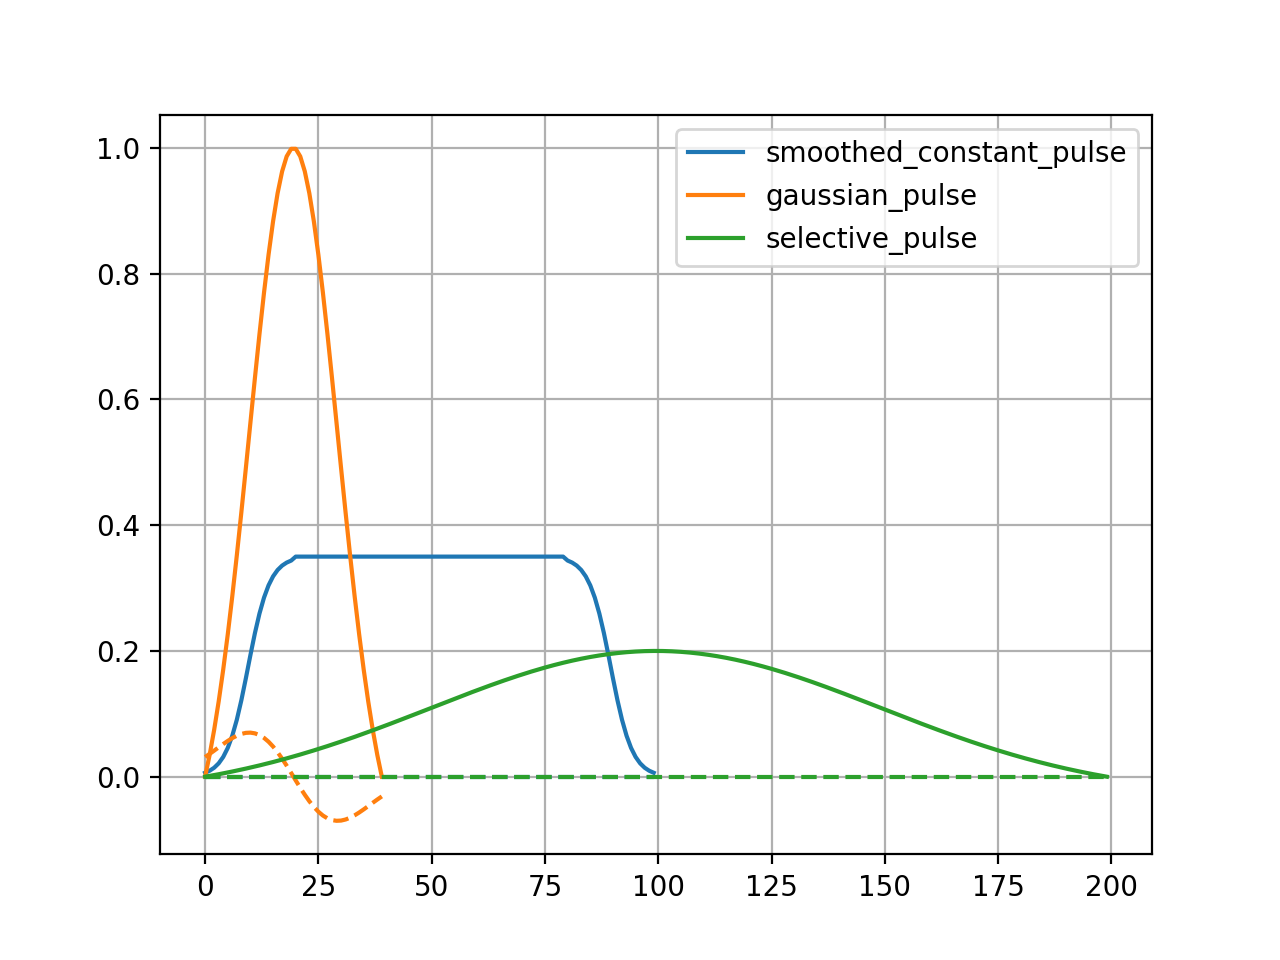

In [11]:
ax = q0.smoothed_constant_pulse.plot(amp=0.35, sigma=20, length=100)
ax = q0.gaussian_pulse.plot(drag=-4, ax=ax)
ax = q0.selective_pulse.plot(amp=0.2, ax=ax)

### Defining a custom pulse

You can define your own pulse by creating a subclass of `sequencing.pulses.Pulse`.

In [12]:
import attr
from sequencing.pulses import Pulse
from sequencing.parameters import NanosecondParameter

def triangle_wave(length):
    t0 = length // 2
    ts = np.linspace(-t0, t0, int(length))
    return 1 - np.abs(ts / t0)

@attr.s
class TrianglePulse(Pulse):
    pulse_func = staticmethod(triangle_wave)
    length = NanosecondParameter(101)

<IPython.core.display.Javascript object>


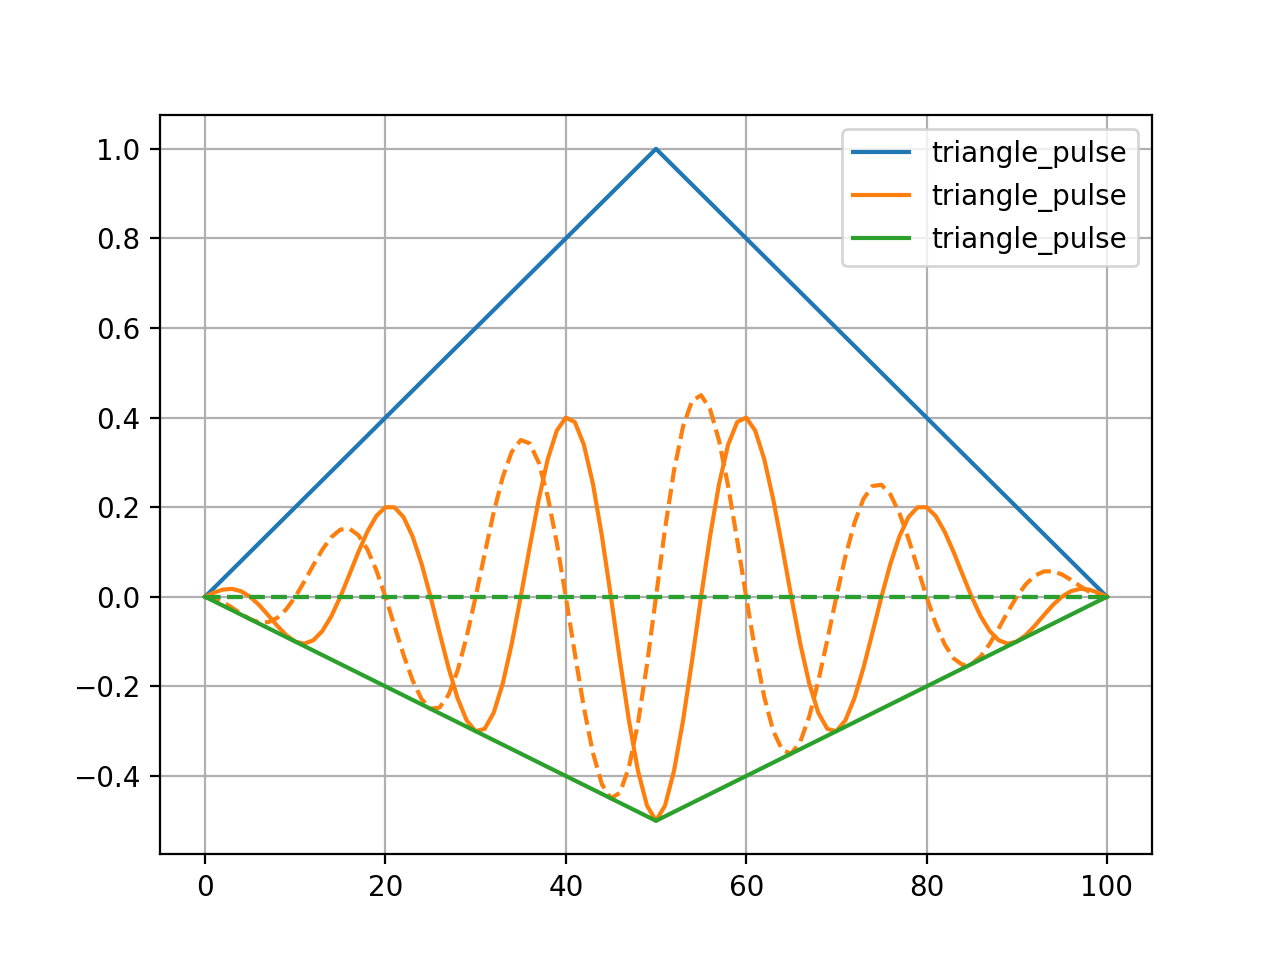

In [13]:
tri = TrianglePulse('triangle_pulse')
ax = tri.plot()
_ = tri.plot(detune=5e-2, amp=0.5, ax=ax)
_ = tri.plot(phase=np.pi, amp=0.5, ax=ax)

In [14]:
q0.add_pulse(cls=TrianglePulse)
print(list(q0.pulses))

['smoothed_constant_pulse', 'gaussian_pulse', 'selective_pulse', 'triangle_pulse']


### Control amplitude noise

Power-law Gaussian noise (["colored noise"](https://en.wikipedia.org/wiki/Colors_of_noise)) can be added to `Pulses` via the parameters `noise_sigma` and `noise_alpha`. The noise is Gaussian distributed with zero mean and a standard deviation of `noise_sigma`, and the power spectral density is proportional to `S(f) = (1/f)**noise_alpha`. `noise_sigma` defaults to `0` (no noise), and `noise_alpha` defaults to `0` (white noise). `noise_alpha = 1` corresponds to 1/f noise.

There is a third parameter, `scale_noise`, which determines whether `noise_sigma` is interpreted as an absolute amplitude (with units of GHz) or relative amplitude (with units of maximum pulse amplitude). By default, `scale_noise = False`, so the noise amplitude is absolute.

<IPython.core.display.Javascript object>


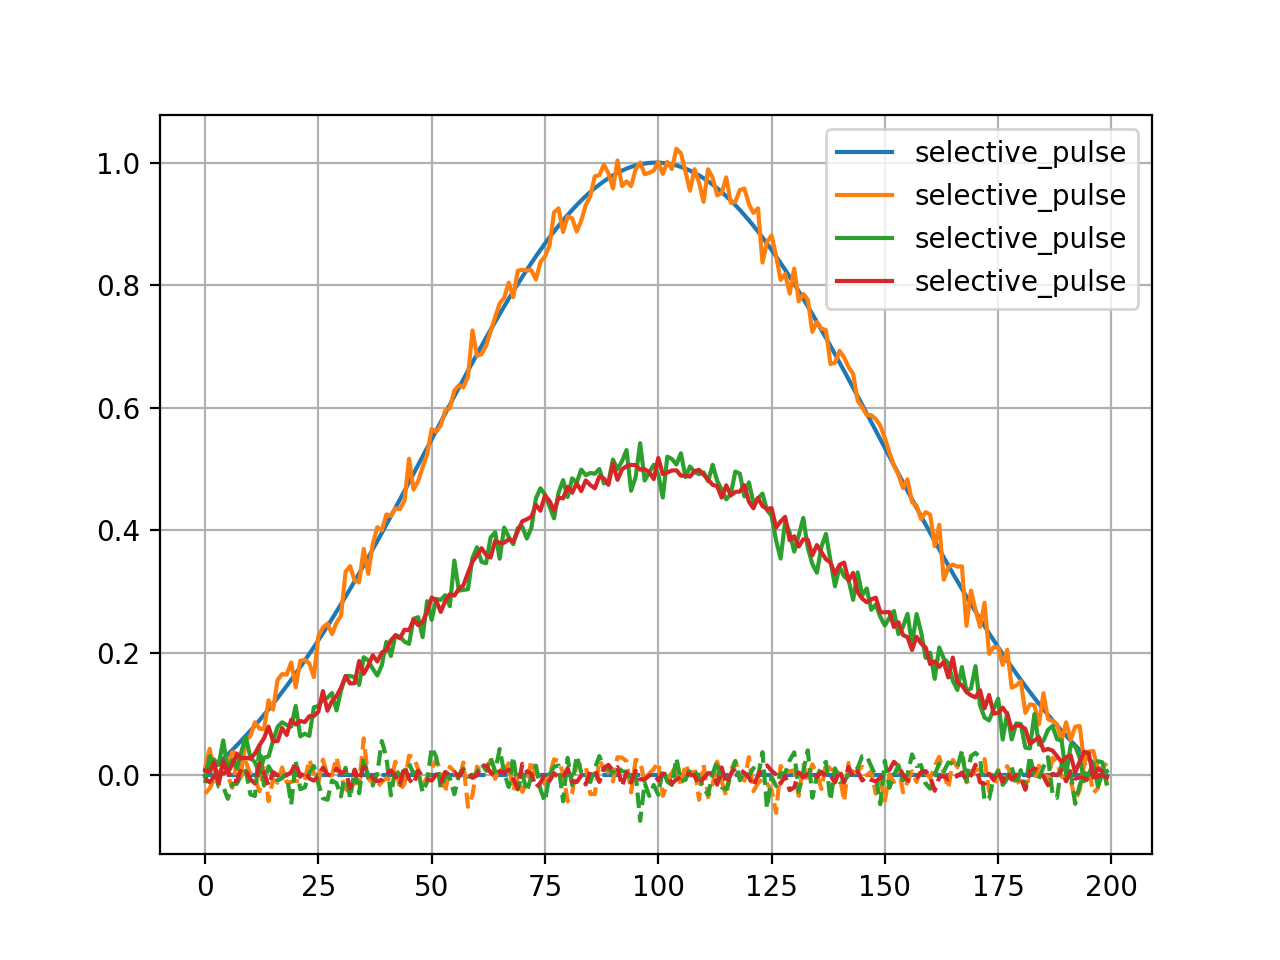

In [15]:
ax = q0.selective_pulse.plot(amp=q0.selective_pulse.amp)
_ = q0.selective_pulse.plot(noise_sigma=2e-2, ax=ax)
_ = q0.selective_pulse.plot(amp=0.5, noise_sigma=2e-2, ax=ax)
_ = q0.selective_pulse.plot(amp=0.5, noise_sigma=2e-2, scale_noise=True, ax=ax)

In [16]:
from qutip.ipynbtools import version_table
version_table()

Software,Version
QuTiP,4.5.2
Numpy,1.19.2
SciPy,1.5.2
matplotlib,3.2.2
Cython,0.29.21
Number of CPUs,4
BLAS Info,INTEL MKL
IPython,7.19.0
Python,"3.7.0 (default, Jun 28 2018, 08:04:48) [MSC v.1912 64 bit (AMD64)]"
OS,nt [win32]
